### Import necessary libraries

In [210]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Load the data and check data detail

In [211]:
tsla = pd.read_csv('TSLA.csv', index_col='Date', parse_dates=True)

In [212]:
tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-16,334.436676,352.399994,334.059998,351.576660,351.576660,79627200
2021-11-17,354.503326,373.213318,351.833344,363.003326,363.003326,94336200
2021-11-18,368.850006,370.666656,358.339996,365.459991,365.459991,62696700
2021-11-19,366.290009,379.573334,364.233337,379.019989,379.019989,64926900
2021-11-22,387.443329,400.649994,377.476654,385.623322,385.623322,99217500


In [213]:
tsla = tsla.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)  #drop columns that we don't need
tsla.head()

,Close
Date,
2021-11-16,351.576660
2021-11-17,363.003326
2021-11-18,365.459991
2021-11-19,379.019989
2021-11-22,385.623322


In [214]:
tsla.index     #check index frequence

DatetimeIndex(['2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-26',
               '2021-11-29', '2021-11-30',
               ...
               '2023-11-02', '2023-11-03', '2023-11-06', '2023-11-07',
               '2023-11-08', '2023-11-09', '2023-11-10', '2023-11-13',
               '2023-11-14', '2023-11-15'],
              dtype='datetime64[ns]', name='Date', length=503, freq=None)

In [215]:
tsla = tsla.asfreq('D').ffill()    #Use forward fill method so that the there is no missing dates and the index frequence can be set as "D"

In [216]:
tsla.index      #check if the frequence is correct

DatetimeIndex(['2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-20', '2021-11-21', '2021-11-22', '2021-11-23',
               '2021-11-24', '2021-11-25',
               ...
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
               '2023-11-14', '2023-11-15'],
              dtype='datetime64[ns]', name='Date', length=730, freq='D')

<Axes: title={'center': 'Tesla Stock Price'}, xlabel='Date'>

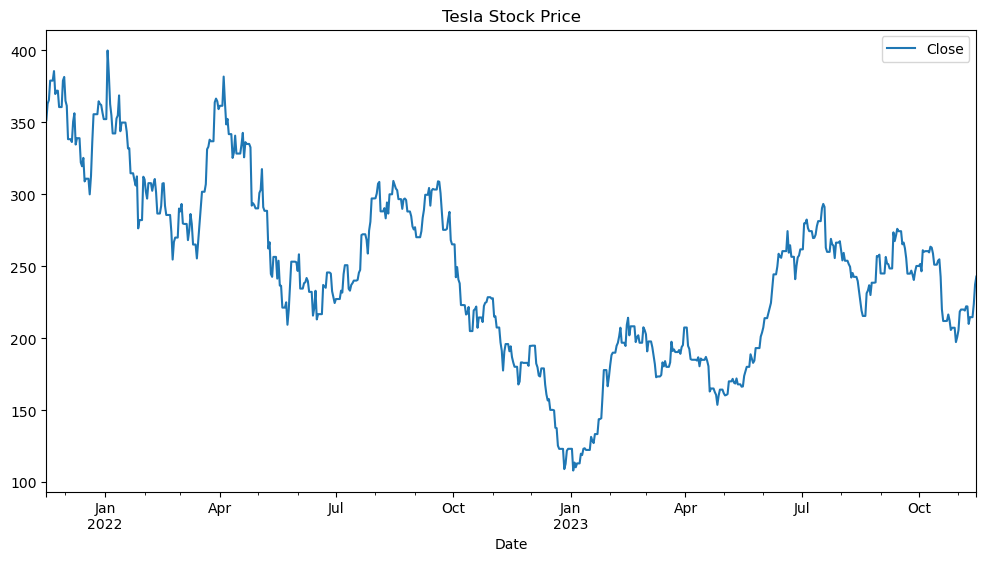

In [217]:
tsla.plot(figsize = (12,6), title = 'Tesla Stock Price')   #plot to visualize the dataset

### Implement ETS

In [218]:
from statsmodels.tsa.seasonal import seasonal_decompose

Use seasonal_decompose to decompose different components. We use the method of additive.

In [219]:
ets_result = seasonal_decompose(tsla['Close'], model='add')   

In [220]:
ets_result

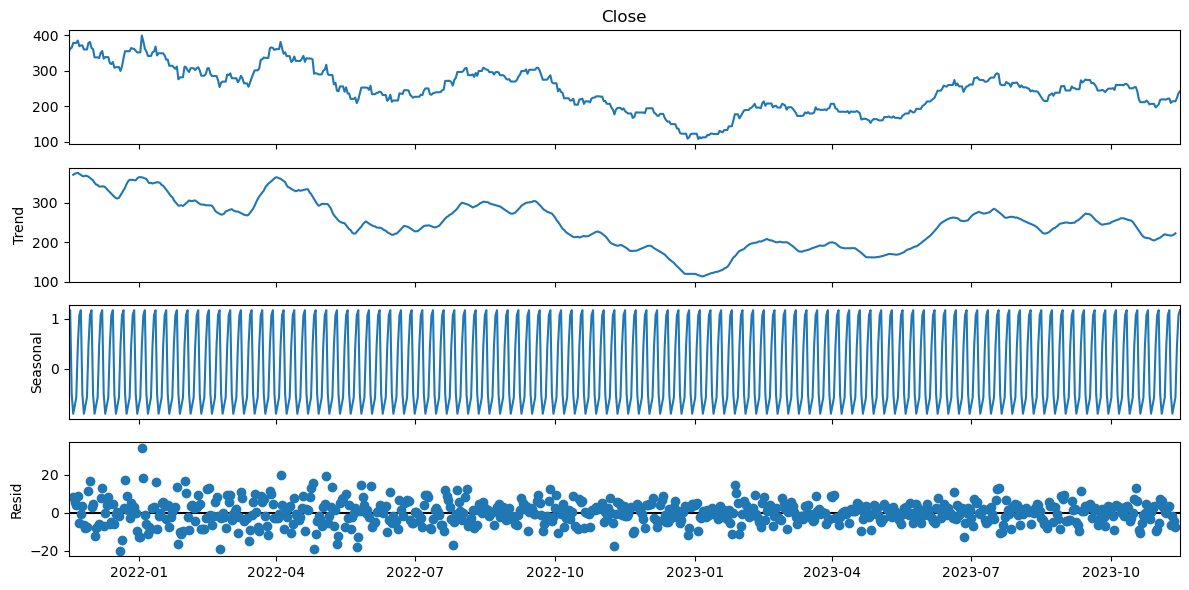

In [221]:
from pylab import rcParams                   #plot the result to get a visualization
rcParams['figure.figsize'] = (12, 6)
ets_result.plot()
plt.show()

### Test for Stationarity

Plot the data again to visually check if it is stationary

<Axes: xlabel='Date'>

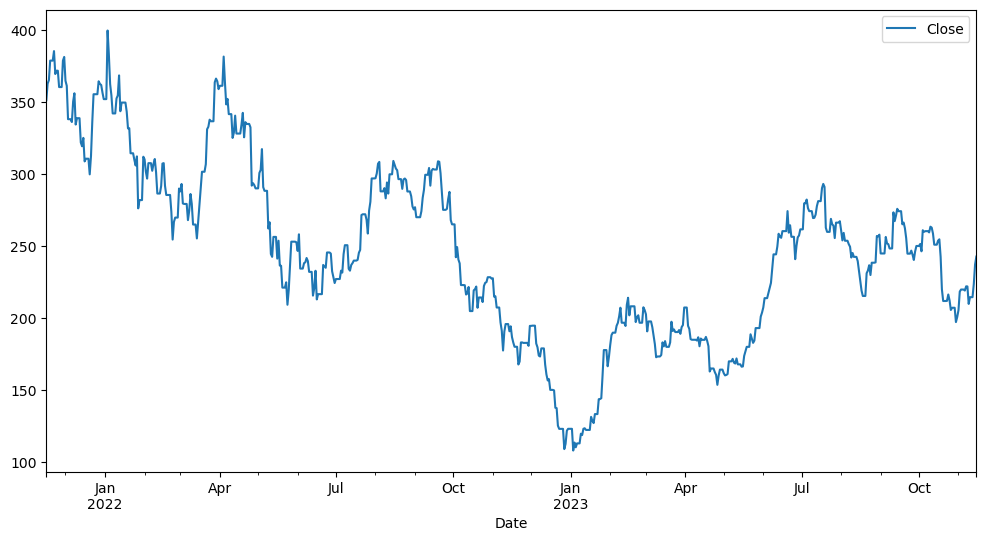

In [222]:
tsla.plot(figsize = (12,6))

We will use Augmented Dicker-Fuller test to check if the data is stationary

In [223]:
from statsmodels.tsa.stattools import adfuller           #import adfuller

In [224]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [225]:
adf_test(tsla['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.159801
p-value                   0.221157
# lags used              18.000000
# observations          711.000000
critical value (1%)      -3.439581
critical value (5%)      -2.865614
critical value (10%)     -2.568939
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller test shows that the data is non-stationary. But we will use Autocorrelation and Partial Autocorrelation plot to double check stationality

In [226]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

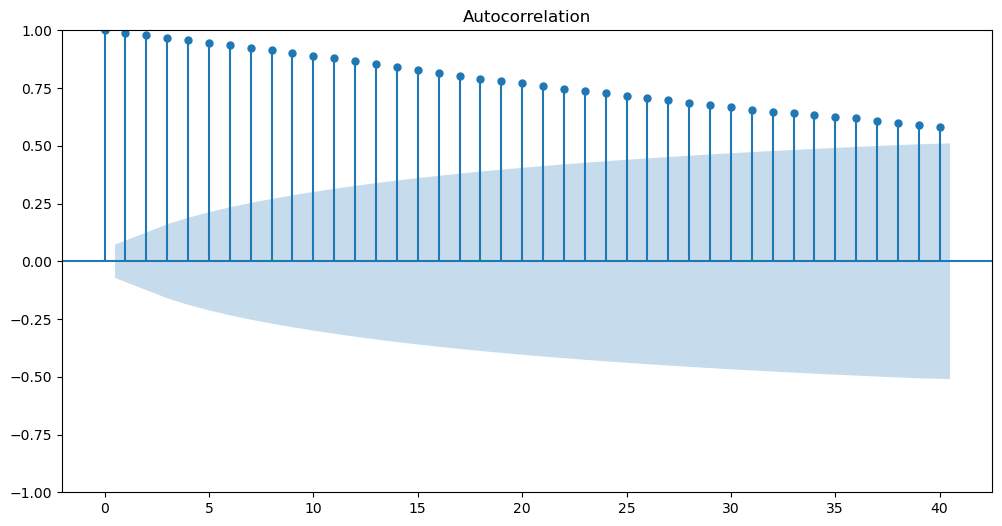

In [227]:
plot_acf(tsla['Close'], lags = 40);

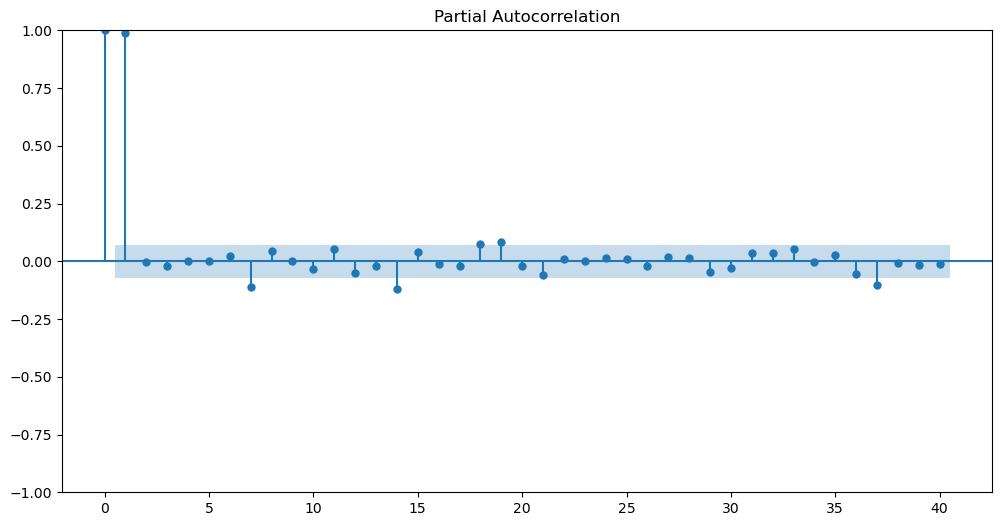

In [228]:
plot_pacf(tsla['Close'].dropna(), lags = 40);

From the plot above, we can see the data is non-stationary. Next we will use differencing to check how many differencing we need to do to make it stationary.

In [229]:
tsla['1d'] = tsla['Close'].diff()

<Axes: xlabel='Date'>

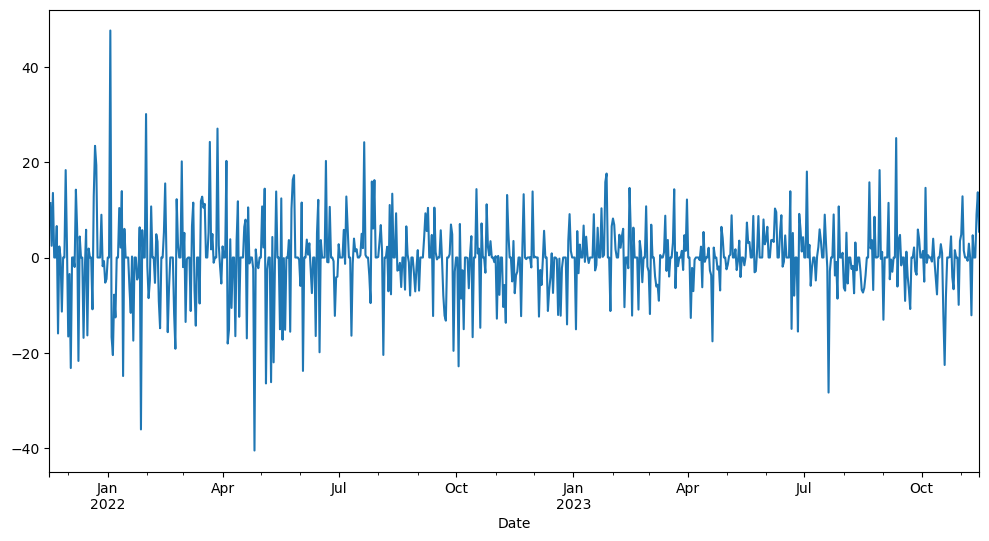

In [230]:
tsla['1d'].plot()         #plot the data to visualize it.

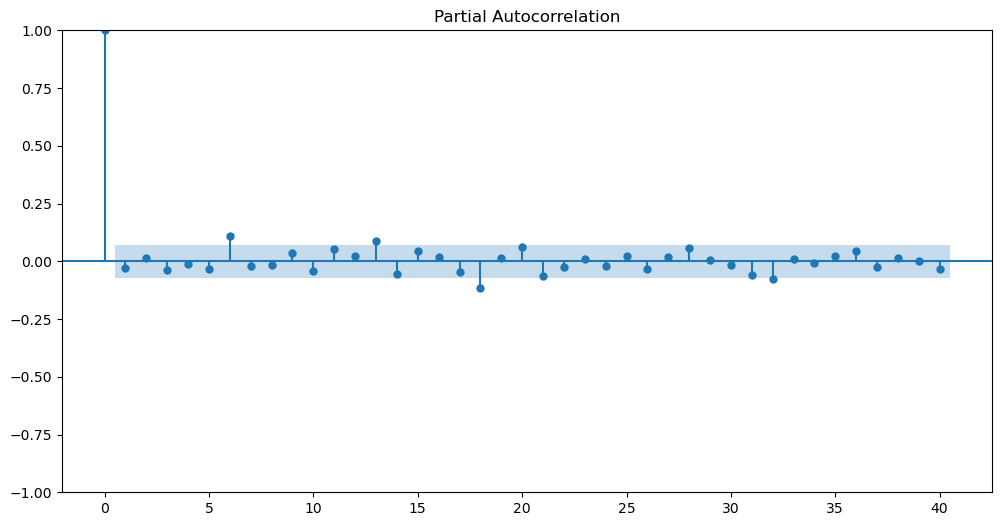

In [231]:
plot_pacf(tsla['1d'].dropna(), lags=40)       #We use partial autocorrelation to visualize the differenced data
plt.show()

We can see that after the first differencing, the data is stationary. We will use this information in our next a few steps.

### Create EWMA 

Next we will create EWMA with two different windows--7 days and 30 days, and plot the data to get an idea of how different the data will be in different windows

In [26]:
tsla['ewma-7'] = tsla['Close'].ewm(span=7).mean()

In [27]:
tsla['ewma-30'] = tsla['Close'].ewm(span=30).mean()

<Axes: xlabel='Date'>

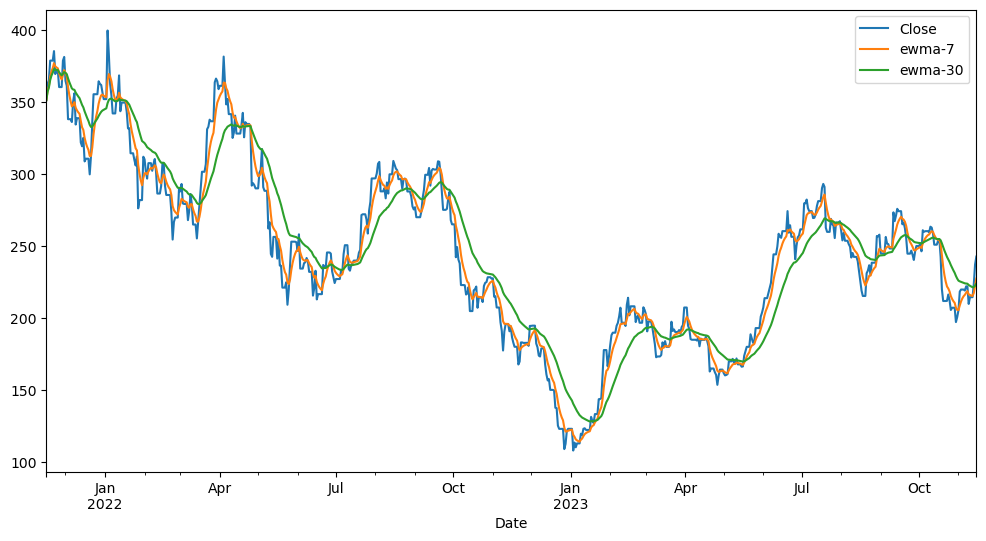

In [28]:
tsla[['Close', 'ewma-7','ewma-30']].plot()

### Create General Forecasting for the next quarter

#### Split Train and Test dataset

In [29]:
train_data = tsla.iloc[:585]
test_data = tsla.iloc[585:]

In [30]:
len(train_data), len(test_data)

(585, 145)

### Method 1: ARIMA model

We will use auto_arima to determine the p,d,and q for ARIMA model and use ARIMA model to predict the future price.

In [232]:
from pmdarima import auto_arima          #import auto_arima

In [233]:
auto_arima(tsla['Close'], start_p=0, start_q=0, max_p=6,
          max_q=6, d=1, trace=True, suppress_warnings=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5121.304, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5122.705, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5122.718, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5119.551, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5123.240, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.149 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2558.776
Date:                Fri, 01 Dec 2023   AIC                           5119.551
Time:                        19:49:05   BIC                           5124.143
Sample:                    11-16-2021   HQIC                          5121.323
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        65.5045      1.967     33.300      0.000      61.649      69.360
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               507.43
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

auto_arima chose the best model for us. So we will use this data to implement in our ARIMA model

In [234]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [238]:
model_arima = SARIMAX(train_data['Close'], order = (0,1,0))
results = model_arima.fit(disp=0)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  585
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2072.219
Date:                Fri, 01 Dec 2023   AIC                           4146.438
Time:                        19:51:10   BIC                           4150.808
Sample:                    11-16-2021   HQIC                          4148.142
                         - 06-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        70.7254      2.407     29.381      0.000      66.007      75.443
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):               373.16
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [239]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
arima_predictions = results.predict(start, end).rename('ARIMA (0,1,0) Prediction')

<Axes: xlabel='Date'>

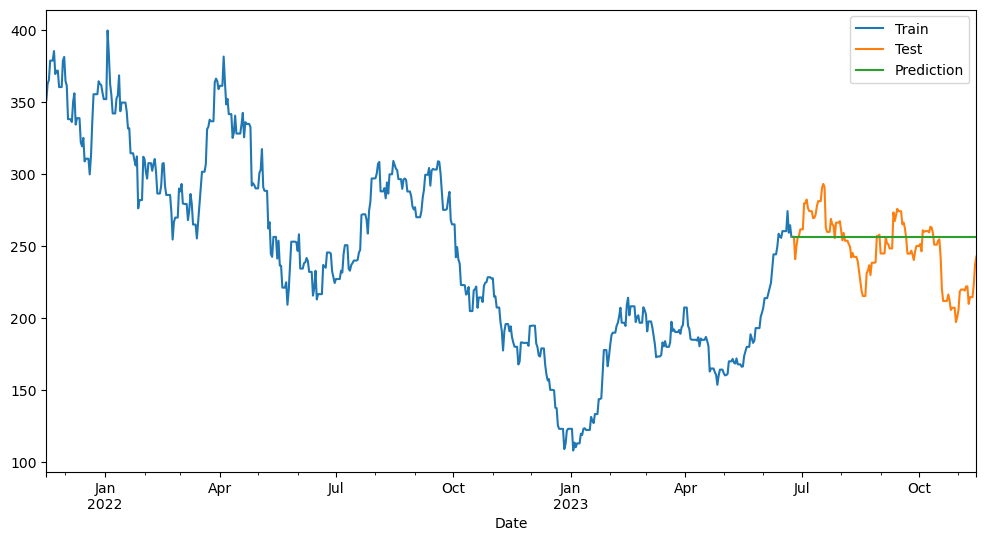

In [240]:
train_data['Close'].plot(legend = True, label = 'Train')
test_data['Close'].plot(legend = True, label = 'Test')
arima_predictions.plot(legend = True, label = 'Prediction')

From the plot above, we can see that the ARIMA model does not do a good job in predicting stock price. We will not use it to predict the future price. Instead, we will use the second method.

### Method 2: Holt-Winters ExponentialSmoothing

We will use ExponentialSmoothing to create a forecast model

In [241]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In this model, we use additive for the trend and seasonal parameters. For the seasonal_periods, we visualize the data having around 19 up-and-down cycles in 2 years, the average cycle is about 38 days, so we set the period with 38. We have even tried different period and found that 38 yields the best result. Then we fit the model with the train_data.

In [242]:
fitted_model = ExponentialSmoothing(train_data['Close'], trend='add',seasonal='add',seasonal_periods=38).fit()

In [243]:
test_prediction = fitted_model.forecast(145)        #forecast the test data using our model

In [244]:
test_prediction                  #Get the forecast result.

2023-06-24    256.970192
2023-06-25    256.115937
2023-06-26    254.767211
2023-06-27    256.028698
2023-06-28    257.366391
                 ...    
2023-11-11    245.526954
2023-11-12    246.447238
2023-11-13    247.323408
2023-11-14    248.251014
2023-11-15    246.370813
Freq: D, Length: 145, dtype: float64

Plot the train_data, test_data and Prediction data to visualize the prediction result.

<Axes: xlabel='Date'>

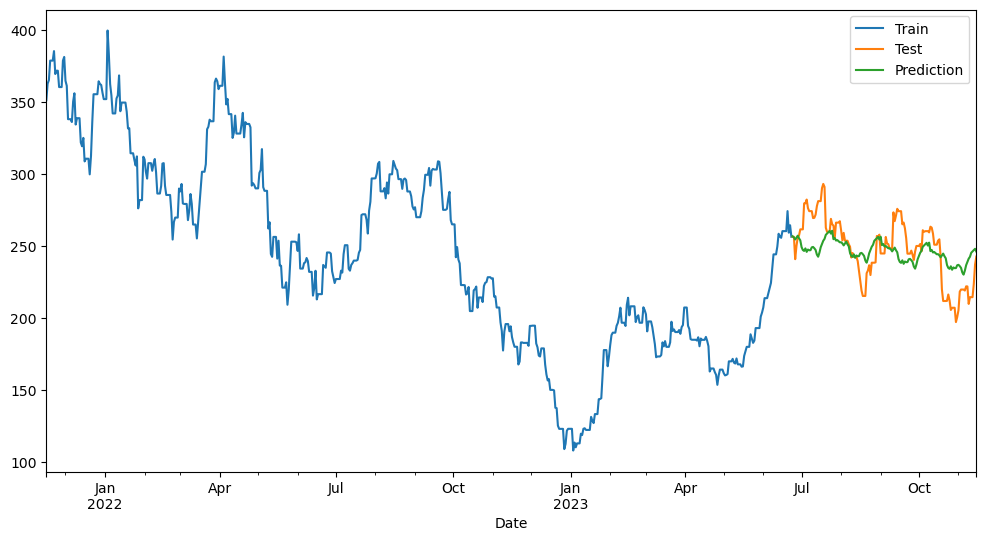

In [245]:
train_data['Close'].plot(legend = True, label = 'Train')
test_data['Close'].plot(legend = True, label = 'Test')
test_prediction.plot(legend = True, label = 'Prediction')

From the plot above, we can see the prediction result is not perfect, but it captured the moving trend of the stock price. We will use MAE, MSE and RMSE to evaluate the result.

### Outcome evaluation

In [246]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [247]:
mean_absolute_error(test_data['Close'], test_prediction)

14.940314367825051

In [248]:
mean_squared_error(test_data['Close'], test_prediction)

359.1764571998192

In [249]:
np.sqrt(mean_squared_error(test_data['Close'], test_prediction))

18.95195127684269

The performance is low. But at this level, we will use this model to predict prices for next quarter.

In [250]:
final_model = ExponentialSmoothing(tsla['Close'], trend='add', seasonal='add', seasonal_periods=38).fit()

In [251]:
future_pred = final_model.forecast(90)

Plot the data and the prediction for the next quarter. 

<Axes: title={'center': 'Tesla Forecasting'}, xlabel='Date'>

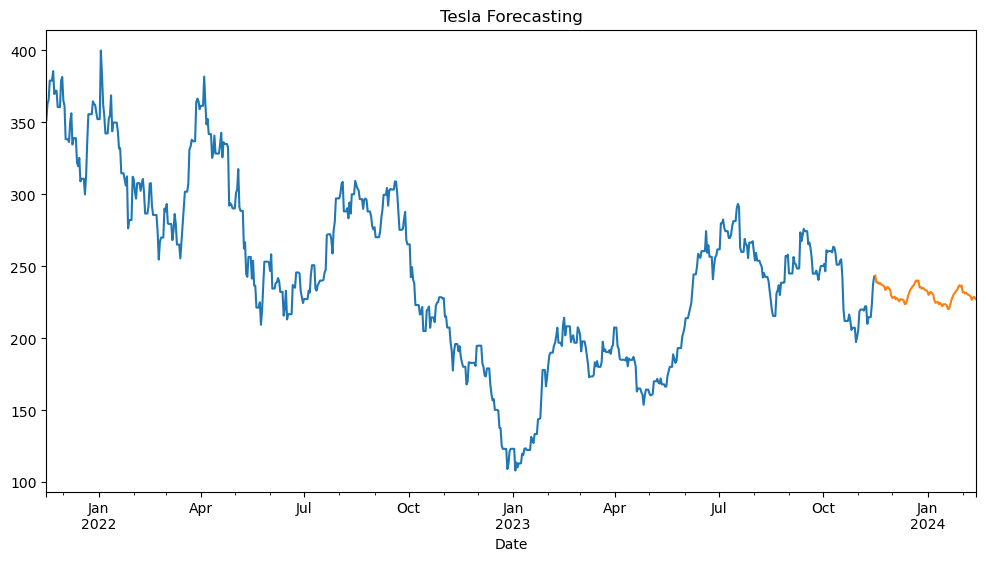

In [252]:
tsla['Close'].plot(figsize = (12,6), title = 'Tesla Forecasting')
future_pred.plot()